In [1]:
import requests
import os
import zipfile
import numpy as np
import pandas as pd
import cv2
import torch

def download_and_extract_file(url, filename):
    extract_path = os.path.splitext(filename)[0]

    if not os.path.exists(filename):
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status() 

            with open(filename, 'wb') as file:
                for chunk in response.iter_content(chunk_size=8192):
                    file.write(chunk)
            print(f"Downloaded '{filename}' successfully.")

            # Open the zip file in read mode
            with zipfile.ZipFile(filename, 'r') as zip_ref:
                # Extract all the contents to the specified directory
                zip_ref.extractall(extract_path)
            
            print(f"Successfully extracted '{filename}' to '{extract_path}'")
        
        except requests.exceptions.RequestException as e:
            print(f"Error downloading '{url}': {e}")
        except IOError as e:
            print(f"Error writing file '{filename}': {e}")
    else:
        print(f"File '{filename}' already exists. Skipping download.")

In [2]:
file_url = "https://www.kaggle.com/api/v1/datasets/download/xhlulu/leafsnap-dataset"
file_name = "leafsnap-dataset.zip"

download_and_extract_file(file_url, file_name)

File 'leafsnap-dataset.zip' already exists. Skipping download.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Path to your dataset
METADATA_PATH = 'leafsnap-dataset/leafsnap-dataset-images.txt'
IMAGES_ROOT = 'leafsnap-dataset/leafsnap-dataset'  # base folder containing all the image paths

def load_metadata(metadata_path, image_type='segmented', source_filter=None):
    """
    Load metadata and return paths and labels.
    - image_type: 'segmented' or 'original'
    - source_filter: None for all, or 'lab'/'field'
    """
    df = pd.read_csv(metadata_path, sep='\t')
    
    if source_filter:
        df = df[df['source'] == source_filter]

    # Choose image type
    image_col = 'segmented_path' if image_type == 'segmented' else 'image_path'
    image_paths = df[image_col].apply(lambda p: os.path.join(IMAGES_ROOT, p)).tolist()
    labels = df['species'].tolist()
    return image_paths, labels

In [4]:
# Load dataset
image_paths, labels = load_metadata(METADATA_PATH, image_type='color')

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Train-test split
train_paths, test_paths, y_train, y_test = train_test_split(image_paths, labels_encoded, test_size=0.2, stratify=labels_encoded)

In [54]:
import torchvision.transforms as transforms

# Define training and test transforms
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Dataset loader class
class LeafDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Datasets
train_dataset = LeafDataset(train_paths, y_train, transform=train_transform)
test_dataset = LeafDataset(test_paths, y_test, transform=test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)


In [105]:
import torch.nn as nn
import torch.nn.functional as F

class LeafCNN(nn.Module):
    def __init__(self, num_classes):
        super(LeafCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 32, 32]

        x = x.view(-1, 64 * 32 * 32)  # Flatten
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class LeafDCNN(nn.Module):
    def __init__(self, num_classes):
        super(LeafDCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 16 * 16, 2048)
        self.fc2 = nn.Linear(2048, 1000)
        self.fc3 = nn.Linear(1000, 500)
        self.fc4 = nn.Linear(500, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv3(x)))  # Conv3 -> ReLU -> MaxPool
        x = F.relu(self.conv4(x))  # Conv4 -> ReLU

        x = x.view(-1, 64 * 16 * 16)  # Flatten

        x = F.relu(self.fc1(x))  # Fully Connected Layer 1
        x = self.dropout(x)
        x = F.relu(self.fc2(x))  # Fully Connected Layer 2
        x = F.relu(self.fc3(x))  # Fully Connected Layer 3
        x = self.fc4(x)  # Softmax Output
        return x
    
class LeafDCNN_BN(nn.Module):
    def __init__(self, num_classes):
        super(LeafDCNN_BN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 4 * 4, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1000)
        self.fc4 = nn.Linear(1000, 500)
        self.fc5 = nn.Linear(500, num_classes)

    def forward(self, x):
        x = self.bn1(self.pool(F.relu(self.conv1(x))))  # Conv1 -> ReLU -> MaxPool -> BN
        x = self.bn2(self.pool(F.relu(self.conv2(x))))  # Conv2 -> ReLU -> MaxPool -> BN
        x = self.bn3(self.pool(F.relu(self.conv3(x))))  # Conv3 -> ReLU -> MaxPool -> BN
        x = self.bn4(self.pool(F.relu(self.conv4(x))))  # Conv4 -> ReLU -> MaxPool -> BN
        x = self.bn5(self.pool(F.relu(self.conv5(x))))  # Conv5 -> ReLU -> MaxPool -> BN

        x = x.view(-1, 128 * 4 * 4)  # Flatten

        x = F.relu(self.fc1(x))  # Fully Connected Layer 1
        x = self.dropout(x)
        x = F.relu(self.fc2(x))  # Fully Connected Layer 2
        x = F.relu(self.fc3(x))  # Fully Connected Layer 3
        x = F.relu(self.fc4(x))  # Fully Connected Layer 4
        x = self.fc5(x)  # Softmax Output
        return x


In [106]:
tensor = torch.tensor([1.0, 2.0]).to("xpu")
device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
device

device(type='xpu')

In [107]:
import torch
from torch import optim

tensor = torch.tensor([1.0, 2.0]).to("xpu")
device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
cnn_model = LeafCNN(num_classes=len(label_encoder.classes_)).to(device)
dcnn_model = LeafDCNN(num_classes=len(label_encoder.classes_)).to(device)
dcnnbn_model = LeafDCNN_BN(num_classes=len(label_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
dcnn_optimizer = optim.Adam(dcnn_model.parameters(), lr=0.001)
dcnnbn_optimizer = optim.Adam(dcnnbn_model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")


In [108]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    cm = confusion_matrix(all_labels, all_preds)
    return cm

In [110]:
def cnn_predict(model, dataloader, device='cpu'):
    model.eval()
    model.to(device)
    
    y_preds = []
    
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_preds.extend(preds.cpu().numpy())
    
    return y_preds


In [68]:
# Train and evaluate basic CNN model
train_model(cnn_model, train_loader, criterion, cnn_optimizer, epochs=10)
cnn_cm = evaluate_model(cnn_model, test_loader)

torch.save(cnn_model.state_dict(),'./leafcnn_model.pt')


Epoch 1, Loss: 3307.5870, Accuracy: 8.38%
Epoch 2, Loss: 2204.3177, Accuracy: 24.15%
Epoch 3, Loss: 1931.3633, Accuracy: 29.99%
Epoch 4, Loss: 1775.7602, Accuracy: 34.35%
Epoch 5, Loss: 1685.9766, Accuracy: 36.43%
Epoch 6, Loss: 1595.6950, Accuracy: 39.56%
Epoch 7, Loss: 1523.3206, Accuracy: 41.39%
Epoch 8, Loss: 1482.0984, Accuracy: 42.63%
Epoch 9, Loss: 1420.6446, Accuracy: 44.56%
Epoch 10, Loss: 1380.9665, Accuracy: 45.89%
Classification Report:
                              precision    recall  f1-score   support

              Abies concolor       0.75      0.90      0.82        50
          Abies nordmanniana       0.83      0.59      0.69        32
              Acer campestre       0.67      0.41      0.51        29
                Acer ginnala       0.80      0.53      0.64        30
                Acer griseum       0.54      0.56      0.55        25
                Acer negundo       0.93      0.83      0.87        46
               Acer palmatum       0.65      0.67      0

In [103]:
# Train and evaluate deeper CNN model
train_model(dcnn_model, train_loader, criterion, dcnn_optimizer, epochs=10)
dcnn_cm = evaluate_model(dcnn_model, test_loader)

torch.save(dcnn_model.state_dict(),'./leafdcnn_model.pt')

Epoch 1, Loss: 465.3550, Accuracy: 2.69%
Epoch 2, Loss: 328.6597, Accuracy: 13.73%
Epoch 3, Loss: 250.4747, Accuracy: 26.66%
Epoch 4, Loss: 210.0243, Accuracy: 35.92%
Epoch 5, Loss: 179.2589, Accuracy: 43.54%
Epoch 6, Loss: 158.4908, Accuracy: 49.15%
Epoch 7, Loss: 142.4509, Accuracy: 53.99%
Epoch 8, Loss: 129.3796, Accuracy: 57.58%
Epoch 9, Loss: 118.3068, Accuracy: 60.42%
Epoch 10, Loss: 109.1980, Accuracy: 63.49%
Classification Report:
                              precision    recall  f1-score   support

              Abies concolor       0.98      0.90      0.94        50
          Abies nordmanniana       0.55      0.81      0.66        32
              Acer campestre       0.91      0.69      0.78        29
                Acer ginnala       0.84      0.87      0.85        30
                Acer griseum       0.78      0.56      0.65        25
                Acer negundo       0.90      0.78      0.84        46
               Acer palmatum       0.84      0.74      0.78       

In [109]:
# Train and evaluate advanced CNN model
train_model(dcnnbn_model, train_loader, criterion, dcnnbn_optimizer, epochs=10)
dcnn_cm = evaluate_model(dcnnbn_model, test_loader)

torch.save(dcnnbn_model.state_dict(),'./leafdcnnbn_model.pt')

Epoch 1, Loss: 386.9236, Accuracy: 8.95%
Epoch 2, Loss: 226.6163, Accuracy: 31.56%
Epoch 3, Loss: 164.9360, Accuracy: 47.45%
Epoch 4, Loss: 134.6720, Accuracy: 55.85%
Epoch 5, Loss: 111.7279, Accuracy: 62.60%
Epoch 6, Loss: 98.2134, Accuracy: 66.70%
Epoch 7, Loss: 83.5862, Accuracy: 71.33%
Epoch 8, Loss: 75.3550, Accuracy: 73.89%
Epoch 9, Loss: 67.5444, Accuracy: 76.22%
Epoch 10, Loss: 61.2804, Accuracy: 78.39%
Classification Report:
                              precision    recall  f1-score   support

              Abies concolor       1.00      0.86      0.92        50
          Abies nordmanniana       1.00      0.72      0.84        32
              Acer campestre       0.86      0.83      0.84        29
                Acer ginnala       0.96      0.87      0.91        30
                Acer griseum       1.00      0.80      0.89        25
                Acer negundo       0.93      0.93      0.93        46
               Acer palmatum       0.89      0.95      0.92        42
 

# PCA + SVM

In [113]:
import numpy as np
from PIL import Image

def load_flattened_images(image_paths, size=(128, 128)):
    data = []
    for path in image_paths:
        img = Image.open(path).convert('L').resize(size)
        img_arr = np.array(img).flatten()  # Flatten to 1D vector
        data.append(img_arr)
    return np.array(data)

X_train_flat = load_flattened_images(train_paths)
X_test_flat = load_flattened_images(test_paths)


In [ ]:
from sklearn.decomposition import PCA

pca_flat = PCA(n_components=150)
X_train_pca_flat = pca_flat.fit_transform(X_train_flat)
X_test_pca_flat = pca_flat.transform(X_test_flat)


In [ ]:
from sklearn.svm import SVC

svm_flat = SVC(kernel='rbf', C=10, gamma=0.01)
svm_flat.fit(X_train_pca_flat, y_train)


SVC(C=10, gamma=0.01)

In [116]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_svm_flat = svm_flat.predict(X_test_pca_flat)
acc_svm_flat = accuracy_score(y_test, y_pred_svm_flat)

print("PCA + SVM Accuracy:", accuracy_score(y_test, y_pred_svm_flat))
print(classification_report(y_test, y_pred_svm_flat, target_names=label_encoder.classes_))

cm_svm_flat = confusion_matrix(y_test, y_pred_svm_flat)


PCA + SVM Accuracy: 0.01749271137026239
                              precision    recall  f1-score   support

              Abies concolor       0.00      0.00      0.00        50
          Abies nordmanniana       0.00      0.00      0.00        32
              Acer campestre       0.00      0.00      0.00        29
                Acer ginnala       0.00      0.00      0.00        30
                Acer griseum       0.00      0.00      0.00        25
                Acer negundo       0.00      0.00      0.00        46
               Acer palmatum       0.00      0.00      0.00        42
          Acer pensylvanicum       0.00      0.00      0.00        31
            Acer platanoides       0.00      0.00      0.00        28
         Acer pseudoplatanus       0.00      0.00      0.00        27
                 Acer rubrum       0.00      0.00      0.00        60
            Acer saccharinum       0.00      0.00      0.00        37
              Acer saccharum       0.00      0.00

c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# HOG + LBP + PCA + SVM

In [117]:
from skimage.feature import hog, local_binary_pattern
from PIL import Image
import numpy as np

def extract_hog_lbp_features(image_paths, size=(128, 128)):
    hog_features = []
    lbp_features = []

    radius = 3
    n_points = 8 * radius

    for path in image_paths:
        img = Image.open(path).convert('L').resize(size)
        img_np = np.array(img)

        # HOG
        hog_feat = hog(img_np, orientations=9, pixels_per_cell=(16, 16),
                       cells_per_block=(2, 2), block_norm='L2-Hys')
        hog_features.append(hog_feat)

        # LBP
        lbp = local_binary_pattern(img_np, n_points, radius, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), density=True)
        lbp_features.append(hist)

    hog_features = np.array(hog_features)
    lbp_features = np.array(lbp_features)
    return np.hstack([hog_features, lbp_features])


In [118]:
X_train_hl = extract_hog_lbp_features(train_paths)
X_test_hl = extract_hog_lbp_features(test_paths)


In [119]:
from sklearn.decomposition import PCA

pca_hl = PCA(n_components=150)
X_train_pca_hl = pca_hl.fit_transform(X_train_hl)
X_test_pca_hl = pca_hl.transform(X_test_hl)


In [120]:
from sklearn.svm import SVC

svm_hl = SVC(kernel='rbf', C=10, gamma=0.01)
svm_hl.fit(X_train_pca_hl, y_train)


SVC(C=10, gamma=0.01)

In [121]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_svm_hl = svm_hl.predict(X_test_pca_hl)
acc_svm_hl = accuracy_score(y_test, y_pred_svm_hl)

print("HOG + LBP + PCA + SVM Accuracy:", acc_svm_hl)
print(classification_report(y_test, y_pred_svm_hl, target_names=label_encoder.classes_))

cm_svm_hl = confusion_matrix(y_test, y_pred_svm_hl)


HOG + LBP + PCA + SVM Accuracy: 0.7351797862001944
                              precision    recall  f1-score   support

              Abies concolor       0.80      0.90      0.85        50
          Abies nordmanniana       0.77      0.75      0.76        32
              Acer campestre       0.74      0.90      0.81        29
                Acer ginnala       0.93      0.83      0.88        30
                Acer griseum       0.92      0.88      0.90        25
                Acer negundo       0.75      0.89      0.81        46
               Acer palmatum       0.75      0.93      0.83        42
          Acer pensylvanicum       0.92      0.74      0.82        31
            Acer platanoides       0.63      0.68      0.66        28
         Acer pseudoplatanus       0.67      0.59      0.63        27
                 Acer rubrum       0.88      0.85      0.86        60
            Acer saccharinum       0.92      0.95      0.93        37
              Acer saccharum       0.8

# Saving

In [122]:
import joblib

# Save Baseline SVM
joblib.dump(svm_flat, "svm_flat.pkl")
joblib.dump(pca_flat, "pca_flat.pkl")

# Save HOG+LBP SVM
joblib.dump(svm_hl, "svm_hl.pkl")
joblib.dump(pca_hl, "pca_hl.pkl")

# Save Label Encoder
joblib.dump(label_encoder, "label_encoder.pkl")


['label_encoder.pkl']

# Comparison

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [126]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

metrics = []

# CNN
y_pred_cnn = cnn_predict(cnn_model, test_loader, 'xpu')
metrics.append(compute_metrics(y_test, y_pred_cnn, "CNN"))

# DCNN
y_pred_dcnn = cnn_predict(dcnn_model, test_loader, 'xpu')
metrics.append(compute_metrics(y_test, y_pred_dcnn, "DCNN"))

# DCNN w/ BN
y_pred_dcnnbn = cnn_predict(dcnnbn_model, test_loader, 'xpu')
metrics.append(compute_metrics(y_test, y_pred_dcnnbn, "DCNNBN"))

# Flattened + PCA + SVM
metrics.append(compute_metrics(y_test, y_pred_svm_flat, "PCA + SVM"))

# HOG + LBP + PCA + SVM
metrics.append(compute_metrics(y_test, y_pred_svm_hl, "HOG+LBP + PCA + SVM"))


c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\peter\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [127]:
import pandas as pd

df_metrics = pd.DataFrame(metrics)
print(df_metrics)


                 Model  Accuracy  Precision    Recall  F1 Score
0                  CNN  0.005021   0.000056  0.005405  0.000111
1                 DCNN  0.004859   0.000056  0.005537  0.000111
2               DCNNBN  0.768707   0.785214  0.760207  0.757698
3            PCA + SVM  0.017493   0.020920  0.009487  0.006627
4  HOG+LBP + PCA + SVM  0.735180   0.744901  0.727763  0.730228


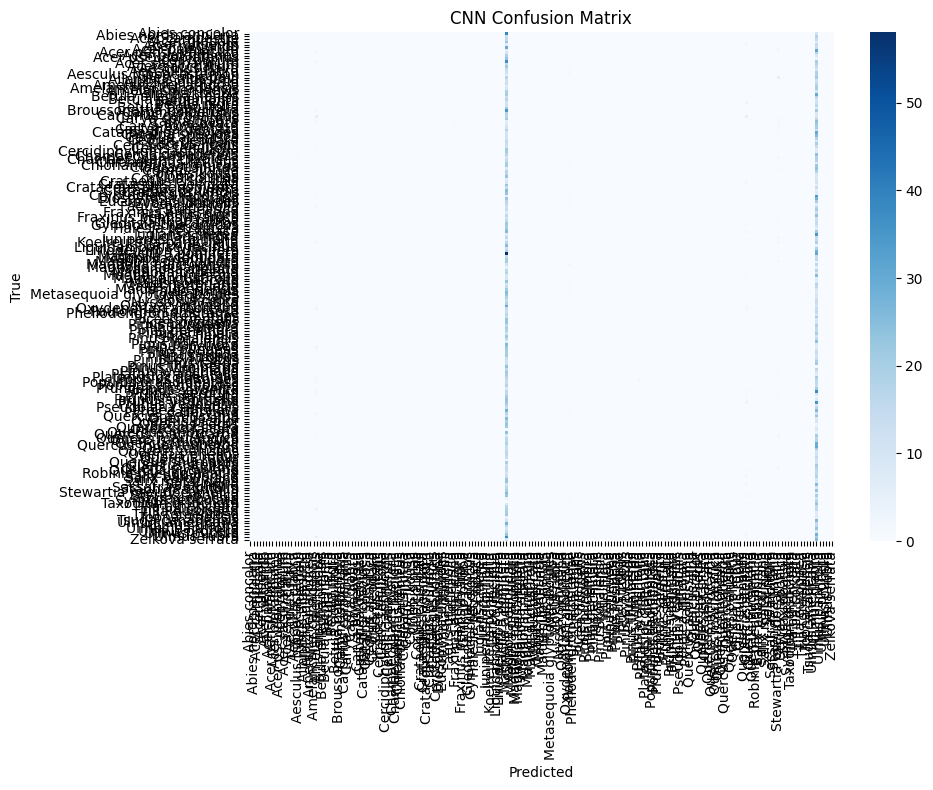

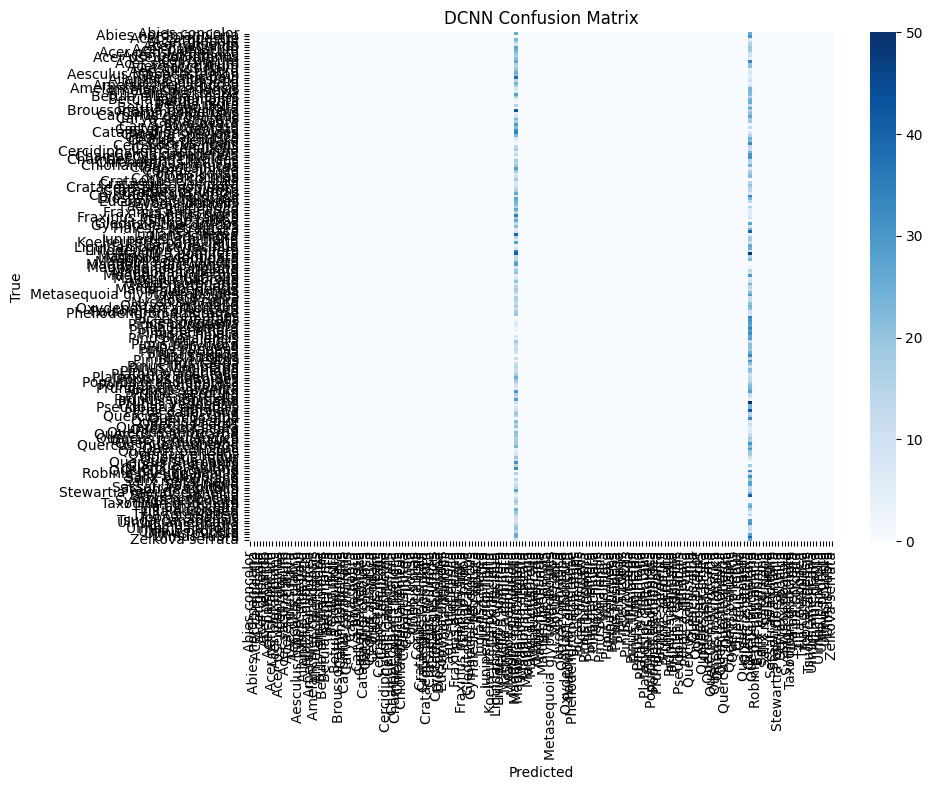

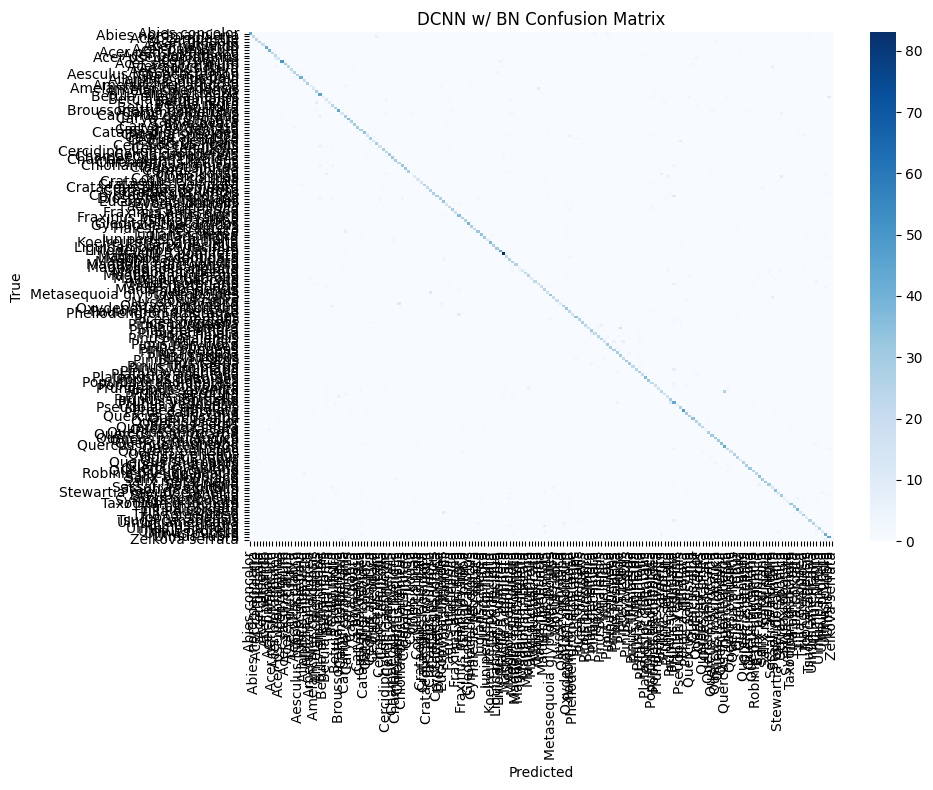

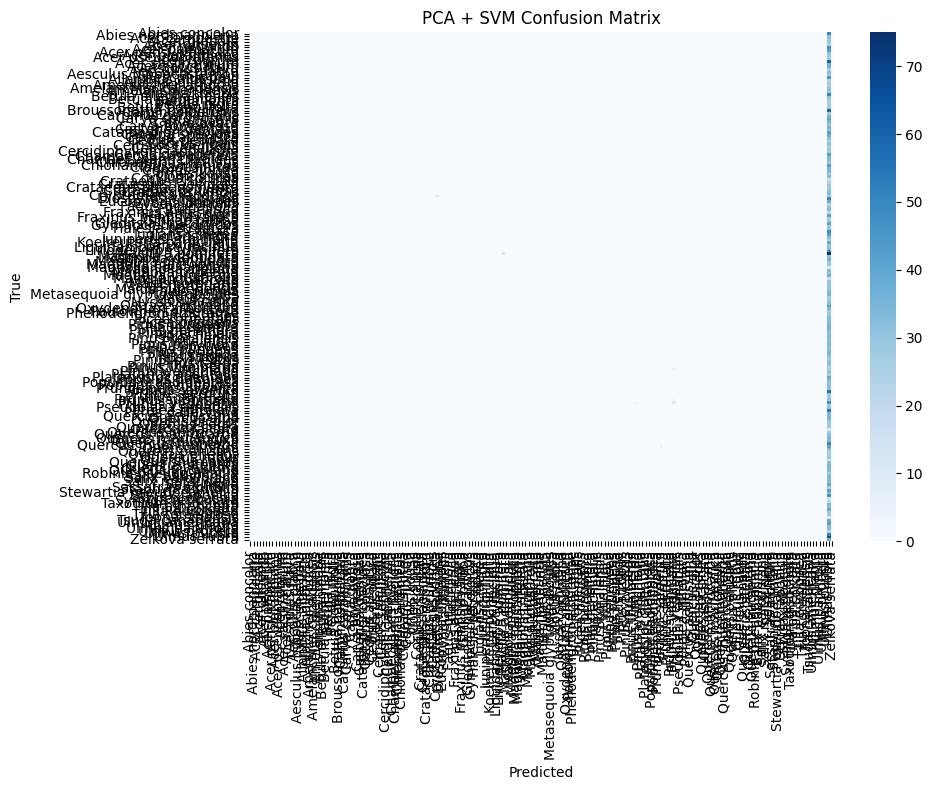

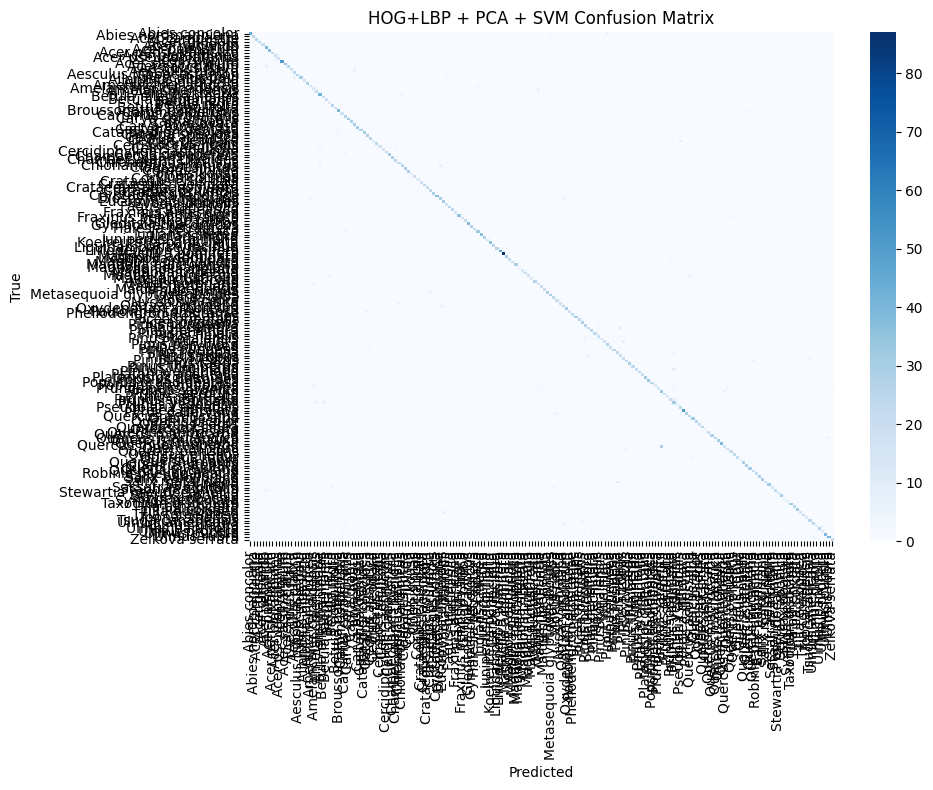

In [136]:
plot_conf_matrix(y_test, y_pred_cnn, label_encoder.classes_, "CNN Confusion Matrix")
plot_conf_matrix(y_test, y_pred_dcnn, label_encoder.classes_, "DCNN Confusion Matrix")
plot_conf_matrix(y_test, y_pred_dcnnbn, label_encoder.classes_, "DCNN w/ BN Confusion Matrix")
plot_conf_matrix(y_test, y_pred_svm_flat, label_encoder.classes_, "PCA + SVM Confusion Matrix")
plot_conf_matrix(y_test, y_pred_svm_hl, label_encoder.classes_, "HOG+LBP + PCA + SVM Confusion Matrix")
